# Example of directly providing ground truth


If you'd like to provide the ground truth directly (rather than using one of the built in sample generators), you can do so with the `Simulation.from_ground_truth` method.

This example creates a ground truth mask using `random_circles` and then creates a simuluated image from that mask.

In [1]:
import numpy as np

from microsim import schema as ms
from microsim.util import ortho_plot


In [2]:
def random_circles(shape: tuple[int, ...], num_circles=5, min_radius=10, max_radius=80):
    ndim = len(shape)
    assert ndim in {2, 3}, "Only 2D and 3D grids are supported"

    # Create an empty grid with floating point for summation
    grid = np.zeros(shape, dtype=float)

    # Define circle properties with larger radii
    circle_radii = np.random.randint(min_radius, max_radius, num_circles)
    circle_centers = np.random.randint(0, max(shape[-2:]), (num_circles, 2))
    if ndim == 3:
        circle_centers = np.concatenate(
            (np.random.randint(0, shape[0], (num_circles, 1)), circle_centers),
            axis=1,
        )

    # Draw unfilled circles with transparency
    for center, radius in zip(circle_centers, circle_radii, strict=False):
        grid_indices = np.ogrid[tuple(slice(0, s) for s in shape)]
        mask_outer = np.zeros(shape, dtype=bool)
        mask_inner = np.zeros(shape, dtype=bool)
        for i, c in enumerate(center):
            mask_outer = mask_outer + (grid_indices[i] - c) ** 2
            mask_inner = mask_inner + (grid_indices[i] - c) ** 2
        mask_outer = mask_outer <= radius**2
        mask_inner = mask_inner <= (radius - 3) ** 2
        grid[mask_outer] += 0.5
        grid[mask_inner] -= 0.5

    # Clip values to keep them within valid range
    return np.clip(grid, 0, 1)

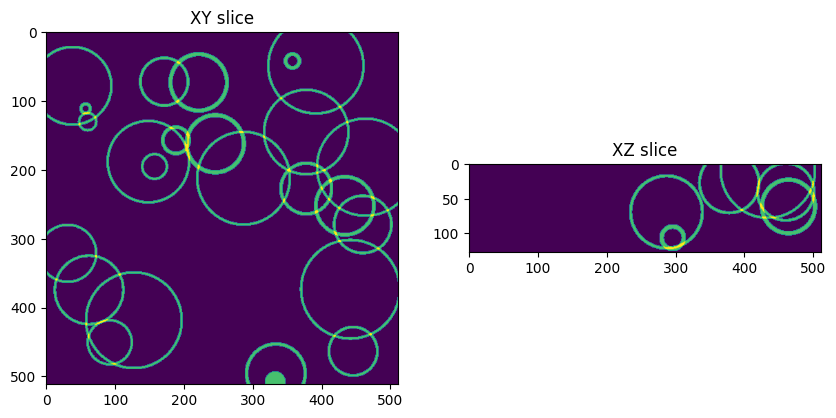

In [5]:
circles = random_circles((128, 512, 512), 32)
ortho_plot(circles)

convolving em_psf with pinhole...: 100%|██████████████████████████████████████| 128/128 [00:00<00:00, 195.20it/s]


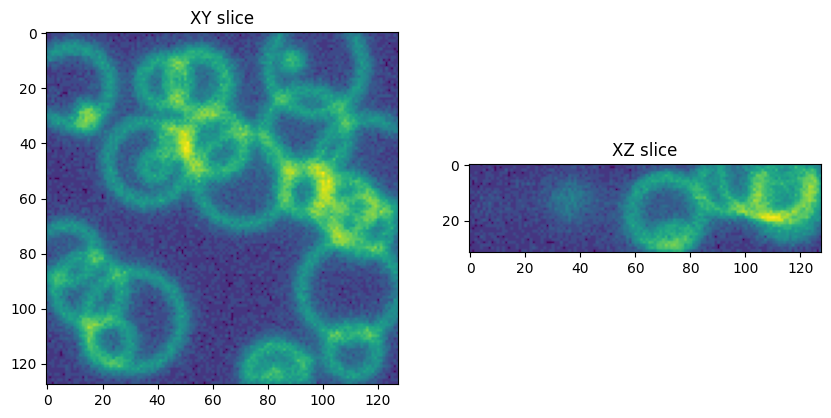

In [6]:
sim = ms.Simulation.from_ground_truth(
    circles,
    scale=(0.04, 0.01, 0.01),
    output_space={"downscale": 4},
    modality=ms.Confocal(),
    detector=ms.CameraCCD(qe=0.82, read_noise=2, bit_depth=12, offset=100),
)

result = sim.run()
ortho_plot(result)